# 03 - Modelo de Detección de Fraccionamiento Transaccional

## Objetivo
Implementar el sistema de **Suspicion Score** para detectar automáticamente patrones de fraccionamiento transaccional basado en los hallazgos del análisis descriptivo.

## Metodología
1. **Feature Engineering**: Construcción de métricas derivadas
2. **Z-Score Calculation**: Normalización estadística respecto al comportamiento histórico
3. **Suspicion Score**: Algoritmo de puntuación ponderada
4. **Sistema de Alertas**: Clasificación de riesgo y generación de casos
5. **Validación**: Pruebas con casos identificados en el EDA

---

## 1. Configuración e Importación de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import time

warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# Cargar datos limpios del notebook anterior
df_clean = pd.read_parquet('../outputs/df_clean.parquet')

## 2. Feature Engineering - Métricas Derivadas

Basándome en los hallazgos del EDA, implementamos las métricas clave para detección de fraccionamiento:

In [3]:
class FeatureEngineering:
    """
    Clase para generar features derivadas para detección de fraccionamiento transaccional
    """
    
    def __init__(self, df, window_hours=24):
        self.df = df.copy()
        self.window_hours = window_hours
        self.features = {}
        
    def calculate_sliding_window_features(self, target_date=None):
        """
        Calcula features en ventana deslizante de 24h para cada usuario
        """
        if target_date is None:
            target_date = self.df['transaction_date'].max()
            
        # Filtrar transacciones en ventana de 24h
        window_start = target_date - timedelta(hours=self.window_hours)
        window_data = self.df[
            (self.df['transaction_date'] >= window_start) & 
            (self.df['transaction_date'] <= target_date)
        ].copy()
        
        print(f"Ventana analizada: {window_start} a {target_date}")
        print(f"Transacciones en ventana: {len(window_data):,}")
        
        # Features por usuario en la ventana
        features_24h = self._build_user_features(window_data)
        
        return features_24h, window_start, target_date
    
    def _build_user_features(self, window_data):
        """
        Construye features clave por usuario - VERSIÓN OPTIMIZADA VECTORIZADA
        """
        # Separar débitos para análisis de fraccionamiento
        debitos = window_data[window_data['transaction_type'] == 'DEBITO'].copy()
        
        if len(debitos) == 0:
            return pd.DataFrame()
        
        print(f"Procesando {len(debitos)} débitos de {debitos['user_id'].nunique()} usuarios...")
        
        # AGREGACIONES MASIVAS VECTORIZADAS
        base_features = debitos.groupby('user_id').agg({
            'transaction_amount': ['count', 'sum', 'mean', 'std', 'min', 'max'],
            'merchant_id': ['nunique'],
            'subsidiary': ['nunique'],
            'transaction_date': ['min', 'max', lambda x: x.dt.hour.nunique()]
        }).reset_index()
        
        # Aplanar nombres de columnas
        base_features.columns = [
            'user_id', 'cnt_24h', 'sum_24h', 'avg_amount', 'amount_std',
            'amount_min', 'amount_max', 'unique_merchants', 'unique_subsidiaries',
            'first_tx', 'last_tx', 'hour_dispersion'
        ]
        
        # MÉTRICAS DERIVADAS VECTORIZADAS
        base_features['amount_cv'] = base_features['amount_std'] / base_features['avg_amount']
        base_features['amount_cv'] = base_features['amount_cv'].fillna(0)
        base_features['amount_range'] = base_features['amount_max'] - base_features['amount_min']
        
        # CONCENTRACIONES 
        print("⚡ Calculando concentraciones...")
        merchant_conc = debitos.groupby('user_id')['merchant_id'].apply(
            lambda x: x.value_counts().iloc[0] / len(x)
        ).reset_index()
        merchant_conc.columns = ['user_id', 'merchant_concentration']
        
        subsidiary_conc = debitos.groupby('user_id')['subsidiary'].apply(
            lambda x: x.value_counts().iloc[0] / len(x)
        ).reset_index()
        subsidiary_conc.columns = ['user_id', 'subsidiary_concentration']
        
        amount_conc = debitos.groupby('user_id')['transaction_amount'].apply(
            lambda x: x.value_counts().iloc[0] / len(x)
        ).reset_index()
        amount_conc.columns = ['user_id', 'same_amount_ratio']
        
        # INTERVALOS DE TIEMPO OPTIMIZADOS
        print("Calculando intervalos temporales...")
        
        def calc_intervals_vectorized(group):
            if len(group) < 2:
                return pd.Series({'avg_interval_minutes': 0, 'std_interval_minutes': 0})
            
            sorted_times = group['transaction_date'].sort_values()
            intervals_minutes = sorted_times.diff().dt.total_seconds().dropna() / 60
            
            return pd.Series({
                'avg_interval_minutes': intervals_minutes.mean(),
                'std_interval_minutes': intervals_minutes.std() if len(intervals_minutes) > 1 else 0
            })
        
        intervals = debitos.groupby('user_id').apply(calc_intervals_vectorized).reset_index()
        
        # MERGE MASIVO (más rápido que loops)
        features = base_features.merge(merchant_conc, on='user_id', how='left')
        features = features.merge(subsidiary_conc, on='user_id', how='left')
        features = features.merge(amount_conc, on='user_id', how='left')
        features = features.merge(intervals, on='user_id', how='left')
        
        # Limpiar columnas temporales
        features = features.drop(['amount_std', 'amount_min', 'amount_max', 'first_tx', 'last_tx'], axis=1)
        
        print(f"Features generadas para {len(features)} usuarios")
        return features
    
    def _calculate_time_intervals(self, user_transactions):
        """
        Calcula intervalos de tiempo entre transacciones sucesivas - OPTIMIZADO
        """
        if len(user_transactions) < 2:
            return pd.Series([])
            
        # Versión vectorizada
        sorted_times = user_transactions['transaction_date'].sort_values()
        intervals = sorted_times.diff().dt.total_seconds() / 60  # Minutos
        return intervals.dropna()

In [4]:
# Instanciar el generador de features
feature_generator = FeatureEngineering(df_clean)

# Generar features para la ventana más reciente
features_24h, window_start, window_end = feature_generator.calculate_sliding_window_features()

print(f"\n📊 Features generadas para {len(features_24h)} usuarios")
print("\n🎯 Primeras 5 filas de features:")
features_24h.head()

Ventana analizada: 2021-11-29 23:59:49 a 2021-11-30 23:59:49
Transacciones en ventana: 73,397
Procesando 55386 débitos de 50240 usuarios...
⚡ Calculando concentraciones...
⚡ Calculando concentraciones...
Calculando intervalos temporales...
Calculando intervalos temporales...
Features generadas para 50240 usuarios

📊 Features generadas para 50240 usuarios

🎯 Primeras 5 filas de features:
Features generadas para 50240 usuarios

📊 Features generadas para 50240 usuarios

🎯 Primeras 5 filas de features:


,user_id,cnt_24h,sum_24h,avg_amount,unique_merchants,unique_subsidiaries,hour_dispersion,amount_cv,amount_range,merchant_concentration,subsidiary_concentration,same_amount_ratio,avg_interval_minutes,std_interval_minutes
0,00008d0ba9a0be7d6ebec62757ede710,1,237.778200,237.778200,1,1,1,0.00000,0.00000,1.0,1.0,1.000000,0.000,0.000000
1,0001895efcf794d07e8e6a9eb5e7f200,1,416.111851,416.111851,1,1,1,0.00000,0.00000,1.0,1.0,1.000000,0.000,0.000000
2,0001c5d9483df35f740087de9198ab89,1,59.444550,59.444550,1,1,1,0.00000,0.00000,1.0,1.0,1.000000,0.000,0.000000
3,0002e7dcfe294227c1fc72019c0b6e7f,3,535.000951,178.333650,1,1,1,0.57735,178.33365,1.0,1.0,0.666667,1.025,0.200347
4,00042abff2a42eec1900754844ab7f7c,1,11.888910,11.888910,1,1,1,0.00000,0.00000,1.0,1.0,1.000000,0.000,0.000000


## 3. Cálculo de Estadísticas Históricas (Baseline)

Para calcular z-scores necesitamos el comportamiento histórico de referencia:

In [6]:
class FastHistoricalBaseline:
    """
    Calcula estadísticas históricas
    """
    
    def __init__(self, df, lookback_days=30):  # Reducir a 30 por defecto
        self.df = df.copy()
        self.lookback_days = lookback_days
        self.baseline_stats = {}
        
    def calculate_historical_baseline_ultra_fast(self, end_date=None):
        """
        Usa rolling windows vectorizado
        """
        if end_date is None:
            end_date = self.df['transaction_date'].max()
            
        start_date = end_date - timedelta(days=self.lookback_days)
        
        print(f"BASELINE: {start_date.date()} a {end_date.date()}")
        
        # FILTRAR DATOS HISTÓRICOS DE UNA VEZ
        historical_data = self.df[
            (self.df['transaction_date'] >= start_date) & 
            (self.df['transaction_date'] < end_date) &
            (self.df['transaction_type'] == 'DEBITO')  # Solo débitos
        ].copy()
        
        print(f"📊 Datos históricos: {len(historical_data):,} transacciones")
        
        if len(historical_data) == 0:
            return pd.DataFrame(), {}
        
        # MÉTODO 1: ROLLING WINDOWS MASIVO Y VECTORIZADO
        historical_features = self._calculate_rolling_features_vectorized(historical_data, start_date, end_date)
        
        if historical_features.empty:
            # MÉTODO 2: FALLBACK - Estadísticas globales simples
            print("Usando estadísticas globales como baseline...")
            return self._calculate_simple_global_baseline(historical_data)
        
        # Calcular estadísticas por usuario y globales
        user_baselines = self._calculate_user_baselines(historical_features)
        global_baselines = self._calculate_global_baselines(historical_features)
        
        return user_baselines, global_baselines
    
    def _calculate_rolling_features_vectorized(self, historical_data, start_date, end_date):
        """
        MÉTODO REVOLUCIONARIO: Rolling windows vectorizado
        """
        print("Usando rolling windows vectorizado...")
        
        # CREAR FECHAS DE REFERENCIA (cada 3 días para acelerar)
        date_range = pd.date_range(start=start_date, end=end_date, freq='3D')
        all_features = []
        
        for i, target_date in enumerate(date_range):
            print(f"Procesando {i+1}/{len(date_range)}: {target_date.date()}")
            
            # Ventana de 24h hacia atrás
            window_start = target_date - timedelta(hours=24)
            window_data = historical_data[
                (historical_data['transaction_date'] >= window_start) & 
                (historical_data['transaction_date'] <= target_date)
            ]
            
            if len(window_data) == 0:
                continue
                
            # AGREGACIONES MASIVAS VECTORIZADAS
            daily_features = self._build_features_ultra_fast(window_data)
            
            if not daily_features.empty:
                daily_features['analysis_date'] = target_date
                all_features.append(daily_features)
        
        if all_features:
            result = pd.concat(all_features, ignore_index=True)
            print(f"Features históricas: {len(result)} registros")
            return result
        else:
            return pd.DataFrame()
    
    def _build_features_ultra_fast(self, window_data):
        """
        Solo features esenciales con agregaciones vectorizadas
        """
        if len(window_data) == 0:
            return pd.DataFrame()
        
        # AGREGACIONES MASIVAS EN UNA SOLA OPERACIÓN
        features = window_data.groupby('user_id').agg({
            'transaction_amount': ['count', 'sum', 'mean', 'std'],
            'merchant_id': ['nunique', lambda x: x.mode().iloc[0] if len(x) > 0 else x.iloc[0]],
            'subsidiary': ['nunique'],
            'transaction_date': ['min', 'max']
        }).reset_index()
        
        # Aplanar columnas
        features.columns = [
            'user_id', 'cnt_24h', 'sum_24h', 'avg_amount', 'amount_std',
            'unique_merchants', 'top_merchant', 'unique_subsidiaries', 'first_tx', 'last_tx'
        ]
        
        # CÁLCULOS VECTORIZADOS RÁPIDOS
        features['amount_cv'] = features['amount_std'] / features['avg_amount']
        features['amount_cv'] = features['amount_cv'].fillna(0)
        
        # CONCENTRACIONES OPTIMIZADAS (más simples pero efectivas)
        merchant_conc = window_data.groupby('user_id')['merchant_id'].apply(
            lambda x: x.value_counts().iloc[0] / len(x)
        ).reset_index()
        merchant_conc.columns = ['user_id', 'merchant_concentration']
        
        same_amount = window_data.groupby('user_id')['transaction_amount'].apply(
            lambda x: x.value_counts().iloc[0] / len(x)
        ).reset_index()
        same_amount.columns = ['user_id', 'same_amount_ratio']
        
        # INTERVALOS SIMPLIFICADOS
        def calc_avg_interval(group):
            if len(group) < 2:
                return 0
            times = group['transaction_date'].sort_values()
            avg_interval = times.diff().dt.total_seconds().mean() / 60
            return avg_interval if not pd.isna(avg_interval) else 0
        
        intervals = window_data.groupby('user_id').apply(calc_avg_interval).reset_index()
        intervals.columns = ['user_id', 'avg_interval_minutes']
        
        # MERGE RÁPIDO
        features = features.merge(merchant_conc, on='user_id', how='left')
        features = features.merge(same_amount, on='user_id', how='left')
        features = features.merge(intervals, on='user_id', how='left')
        
        # Limpiar
        features = features.drop(['amount_std', 'top_merchant', 'first_tx', 'last_tx'], axis=1)
        
        return features
    
    def _calculate_simple_global_baseline(self, historical_data):
        """
        Baseline global súper simple pero efectivo
        """
        print("Calculando baseline global simplificado...")
        
        # Agregaciones globales por usuario
        user_stats = historical_data.groupby('user_id').agg({
            'transaction_amount': ['count', 'sum', 'mean'],
            'merchant_id': ['nunique'],
        }).reset_index()
        
        user_stats.columns = ['user_id', 'cnt_avg', 'sum_avg', 'amount_avg', 'merchants_avg']
        
        # Estadísticas globales
        global_stats = {
            'cnt_24h_mean': user_stats['cnt_avg'].mean(),
            'cnt_24h_std': user_stats['cnt_avg'].std(),
            'sum_24h_mean': user_stats['sum_avg'].mean(),
            'sum_24h_std': user_stats['sum_avg'].std(),
            'avg_amount_mean': user_stats['amount_avg'].mean(),
            'avg_amount_std': user_stats['amount_avg'].std(),
        }
        
        return pd.DataFrame(), global_stats
    
    def _generate_historical_features(self, historical_data, start_date, end_date):
        """
        Genera features para múltiples ventanas de 24h
        """
        all_features = []
        current_date = start_date + timedelta(days=1)
        
        feature_gen = FeatureEngineering(historical_data)
        
        # Procesar en lotes en lugar de día por día
        batch_size = 7  # Procesar 7 días a la vez
        dates_to_process = []
        
        while current_date <= end_date:
            dates_to_process.append(current_date)
            current_date += timedelta(days=1)
        
        print(f"Procesando {len(dates_to_process)} días en lotes de {batch_size}...")
        
        # Procesar en lotes para mayor eficiencia
        for i in range(0, len(dates_to_process), batch_size):
            batch_dates = dates_to_process[i:i+batch_size]
            
            for date in batch_dates:
                try:
                    daily_features, _, _ = feature_gen.calculate_sliding_window_features(date)
                    if not daily_features.empty:
                        daily_features['analysis_date'] = date
                        all_features.append(daily_features)
                except Exception as e:
                    print(f"Error procesando {date}: {e}")
                    continue
            
            print(f"✅ Procesado lote {i//batch_size + 1}/{(len(dates_to_process)-1)//batch_size + 1}")
        
        if all_features:
            result = pd.concat(all_features, ignore_index=True)
            print(f"✅ Features históricas generadas: {len(result)} registros")
            return result
        else:
            return pd.DataFrame()
    
    def _calculate_user_baselines(self, historical_features):
        """
        Calcula media y std por usuario
        """
        if historical_features.empty:
            return pd.DataFrame()
            
        numeric_cols = ['cnt_24h', 'sum_24h', 'avg_amount', 'unique_merchants', 
                       'merchant_concentration', 'same_amount_ratio', 'avg_interval_minutes']
        
        # Filtrar solo columnas que existen
        existing_cols = [col for col in numeric_cols if col in historical_features.columns]
        
        if not existing_cols:
            return pd.DataFrame()
        
        user_stats = historical_features.groupby('user_id')[existing_cols].agg(['mean', 'std']).reset_index()
        user_stats.columns = ['user_id'] + [f"{col[0]}_{col[1]}" for col in user_stats.columns[1:]]
        
        return user_stats
    
    def _calculate_global_baselines(self, historical_features):
        """
        Calcula estadísticas globales
        """
        if historical_features.empty:
            return {}
            
        numeric_cols = ['cnt_24h', 'sum_24h', 'avg_amount', 'unique_merchants', 
                       'merchant_concentration', 'same_amount_ratio', 'avg_interval_minutes']
        
        # Filtrar solo columnas que existen
        existing_cols = [col for col in numeric_cols if col in historical_features.columns]
        
        global_stats = {}
        for col in existing_cols:
            global_stats[f"{col}_mean"] = historical_features[col].mean()
            global_stats[f"{col}_std"] = historical_features[col].std()
            
        return global_stats

In [ ]:
# Calcular baseline histórico
baseline_calculator = FastHistoricalBaseline(df_clean, lookback_days=30)
user_baselines, global_baselines = baseline_calculator.calculate_historical_baseline_ultra_fast()

print(f"\n📊 Baselines calculado:")
print(f"👥 Usuarios con historia: {len(user_baselines)}")
print(f"🌍 Métricas globales: {len(global_baselines)}")

if not user_baselines.empty:
    print("\n📈 Muestra de baselines por usuario:")
    print(user_baselines.head(3))
    
print("\n🌍 Estadísticas globales (muestra):")
for key, value in list(global_baselines.items())[:5]:
    print(f"{key}: {value:.4f}")

BASELINE: 2021-11-09 a 2021-11-30
📊 Datos históricos: 1,353,545 transacciones
Usando rolling windows vectorizado...
Procesando 1/8: 2021-11-09
Procesando 2/8: 2021-11-12
📊 Datos históricos: 1,353,545 transacciones
Usando rolling windows vectorizado...
Procesando 1/8: 2021-11-09
Procesando 2/8: 2021-11-12
Procesando 3/8: 2021-11-15
Procesando 3/8: 2021-11-15
Procesando 4/8: 2021-11-18
Procesando 4/8: 2021-11-18
Procesando 5/8: 2021-11-21
Procesando 5/8: 2021-11-21
Procesando 6/8: 2021-11-24
Procesando 6/8: 2021-11-24
Procesando 7/8: 2021-11-27
Procesando 7/8: 2021-11-27
Procesando 8/8: 2021-11-30
Procesando 8/8: 2021-11-30
Features históricas: 385543 registros
Features históricas: 385543 registros

📊 Baselines calculado:
👥 Usuarios con historia: 289903
🌍 Métricas globales: 14

📈 Muestra de baselines por usuario:
                            user_id  cnt_24h_mean  cnt_24h_std  sum_24h_mean  \
0  000004f4a6f3ac93f454a5dc04b2a252           1.0          NaN      47.55564   
1  00007dc2a5f94a

## 4. Algoritmo de Suspicion Score

Implementamos el algoritmo principal de scoring basado en z-scores:

In [43]:
class SuspicionScoreCalculator:
    """
    🚀 Calcula el Suspicion Score para detección de fraccionamiento
    Sin loops, 100% vectorizado
    """
    
    def __init__(self, user_baselines, global_baselines):
        self.user_baselines = user_baselines
        self.global_baselines = global_baselines
        
        # Pesos para cada métrica (basados en hallazgos del EDA)
        self.weights = {
            'cnt_24h': 3.5,              # Frecuencia alta muy importante
            'sum_24h': 1.0,              # Volumen moderado
            'avg_interval_minutes': 1.5, # Intervalos cortos menos decisivos
            'same_amount_ratio': 1.0,    # Montos repetidos menos decisivos
            'merchant_concentration': 1.0, # Concentración moderada
            'amount_cv': -0.3,           # Poca variabilidad menos decisiva
            'unique_merchants': -0.3,    # Pocos comercios menos decisivo
            'hour_dispersion': -0.3      # Concentración horaria menos decisiva
        }
        
        self.suspicion_threshold = 4.0  # Umbral aumentado para reducir falsos positivos
        
        # PRE-OPTIMIZACIÓN: Crear lookup de baselines indexado por user_id
        if not user_baselines.empty:
            self._prepare_baseline_lookup()
        
    def _prepare_baseline_lookup(self):
        """
        rear diccionarios de lookup O(1) vectorizados
        """
        print("Preparando lookup tables rápidos con vectorización...")
        
        #  USAR PANDAS MULTIINDEX PARA LOOKUP
        self.user_baseline_dict = {}
        
        # Crear lookup para cada métrica usando pandas vectorizado
        user_ids = self.user_baselines['user_id'].values
        
        for metric in self.weights.keys():
            mean_col = f"{metric}_mean"
            std_col = f"{metric}_std"
            
            # Obtener valores usando pandas vectorizado
            if mean_col in self.user_baselines.columns:
                means = self.user_baselines[mean_col].values
                stds = self.user_baselines[std_col].values if std_col in self.user_baselines.columns else np.ones(len(user_ids))
            else:
                means = np.full(len(user_ids), self.global_baselines.get(f"{metric}_mean", 0))
                stds = np.full(len(user_ids), self.global_baselines.get(f"{metric}_std", 1))
            
            # Crear diccionarios vectorizados
            self.user_baseline_dict[f"{metric}_mean"] = dict(zip(user_ids, means))
            self.user_baseline_dict[f"{metric}_std"] = dict(zip(user_ids, stds))
        
        print(f"✅ Lookup creado para {len(user_ids)} usuarios")
        
        #  CREAR FUNCIÓN DE LOOKUP VECTORIZADA
        self.user_baseline_lookup = self.user_baseline_dict
        
    def calculate_z_scores(self, features_df):
        """
        Z-scores 100% vectorizados sin loops - ~100x más rápido
        """
        start_time = time.time()
        z_scores_df = features_df.copy()
        
        print(f" Calculando z-scores para {len(features_df)} usuarios...")
        
        #  STEP 1: Obtener user_ids como numpy array
        user_ids = features_df['user_id'].values
        
        for metric in self.weights.keys():
            if metric not in features_df.columns:
                continue
                
            #  VECTORIZACIÓN TOTAL usando diccionarios optimizados
            global_mean = self.global_baselines.get(f"{metric}_mean", 0)
            global_std = self.global_baselines.get(f"{metric}_std", 1)
            
            # Usar dict.get vectorizado para lookup
            mean_lookup = self.user_baseline_lookup.get(f"{metric}_mean", {})
            std_lookup = self.user_baseline_lookup.get(f"{metric}_std", {})
            
            means = np.array([mean_lookup.get(uid, global_mean) for uid in user_ids])
            stds = np.array([std_lookup.get(uid, global_std) for uid in user_ids])
            
            #  CÁLCULO VECTORIZADO TOTAL
            current_values = features_df[metric].values
            stds = np.where(stds == 0, 1, stds)  # Evitar división por cero
            z_scores = (current_values - means) / stds
            z_scores_df[f"z_{metric}"] = z_scores
        
        elapsed = time.time() - start_time
        print(f"✅ Z-scores calculados en {elapsed:.2f} segundos")
        return z_scores_df
    
    def calculate_suspicion_scores(self, z_scores_df):
        """
        Calcula el Suspicion Score final usando pesos - 100% vectorizado
        """
        start_time = time.time()
        scores_df = z_scores_df.copy()
        
        print(f" Calculando Suspicion Scores para {len(scores_df)} usuarios...")
        
        #  INICIALIZAR SCORE VECTORIZADO
        scores_df['suspicion_score'] = np.zeros(len(scores_df))
        
        #  CÁLCULO VECTORIZADO TOTAL - Sin loops
        for metric, weight in self.weights.items():
            z_col = f"z_{metric}"
            if z_col not in scores_df.columns:
                continue
                
            z_values = scores_df[z_col].values
            
            # Manejar casos especiales vectorizados
            if metric == 'avg_interval_minutes':
                # Para intervalos: valores muy bajos son sospechosos (z-score negativo alto)
                contribution = weight * np.abs(z_values) * np.where(z_values < 0, 1, 0.5)
            else:
                contribution = weight * z_values
            
            scores_df['suspicion_score'] += contribution
        
        # Reducir impacto de métricas si cnt_24h es bajo
        low_tx_filter = scores_df['cnt_24h'] <= 3
        scores_df.loc[low_tx_filter, 'suspicion_score'] *= 0.5

        #  CLASIFICACIÓN VECTORIZADA
        scores_df['risk_level'] = pd.cut(
            scores_df['suspicion_score'],
            bins=[-np.inf, 1, 2.5, 4, np.inf],
            labels=['Bajo', 'Medio', 'Alto', 'Crítico']
        )
        
        scores_df['flag_suspicious'] = scores_df['suspicion_score'] >= self.suspicion_threshold
        
        elapsed = time.time() - start_time
        print(f"✅ Suspicion Scores calculados en {elapsed:.3f} segundos")
        
        return scores_df
    
    def generate_alerts(self, scores_df):
        """
        🚀 : Genera alertas para casos sospechosos
        """
        start_time = time.time()
        
        #  FILTRADO VECTORIZADO
        alerts = scores_df[scores_df['flag_suspicious']].copy()
        alerts = alerts.sort_values('suspicion_score', ascending=False)
        
        #  CLASIFICACIÓN VECTORIZADA
        alerts['investigation_priority'] = pd.cut(
            alerts['suspicion_score'],
            bins=[3, 5, 8, np.inf],
            labels=['Media', 'Alta', 'Crítica']
        )
        
        elapsed = time.time() - start_time
        print(f"✅ Alertas generadas en {elapsed:.3f} segundos")
        
        return alerts

print("🚨 Clase SuspicionScoreCalculator ULTRA  creada correctamente")

🚨 Clase SuspicionScoreCalculator ULTRA  creada correctamente


## 5. Ejecución del Modelo de Detección

Ejecutamos el pipeline completo de detección:

In [41]:
# Instanciar el calculador de scores
score_calculator = SuspicionScoreCalculator(user_baselines, global_baselines)

# Calcular z-scores
print("🔢 Calculando z-scores...")
z_scores_df = score_calculator.calculate_z_scores(features_24h)

# Calcular suspicion scores
print("🎯 Calculando Suspicion Scores...")
final_scores = score_calculator.calculate_suspicion_scores(z_scores_df)

# Generar alertas
print("🚨 Generando alertas...")
alerts = score_calculator.generate_alerts(final_scores)

print(f"\n📊 Resultados del análisis:")
print(f"👥 Total usuarios analizados: {len(final_scores)}")
print(f"🚨 Casos sospechosos detectados: {len(alerts)}")
print(f"📈 Tasa de detección: {len(alerts)/len(final_scores)*100:.2f}%")

print("\n🎯 Distribución por nivel de riesgo:")
print(final_scores['risk_level'].value_counts())

Preparando lookup tables rápidos con vectorización...
✅ Lookup creado para 289903 usuarios
🔢 Calculando z-scores...
 Calculando z-scores para 50240 usuarios...
✅ Z-scores calculados en 0.18 segundos
🎯 Calculando Suspicion Scores...
 Calculando Suspicion Scores para 50240 usuarios...
✅ Suspicion Scores calculados en 0.012 segundos
🚨 Generando alertas...
✅ Alertas generadas en 0.001 segundos

📊 Resultados del análisis:
👥 Total usuarios analizados: 50240
🚨 Casos sospechosos detectados: 7
📈 Tasa de detección: 0.01%

🎯 Distribución por nivel de riesgo:
risk_level
Bajo       21040
Medio       1046
Alto         108
Crítico        7
Name: count, dtype: int64
✅ Lookup creado para 289903 usuarios
🔢 Calculando z-scores...
 Calculando z-scores para 50240 usuarios...
✅ Z-scores calculados en 0.18 segundos
🎯 Calculando Suspicion Scores...
 Calculando Suspicion Scores para 50240 usuarios...
✅ Suspicion Scores calculados en 0.012 segundos
🚨 Generando alertas...
✅ Alertas generadas en 0.001 segundos

📊

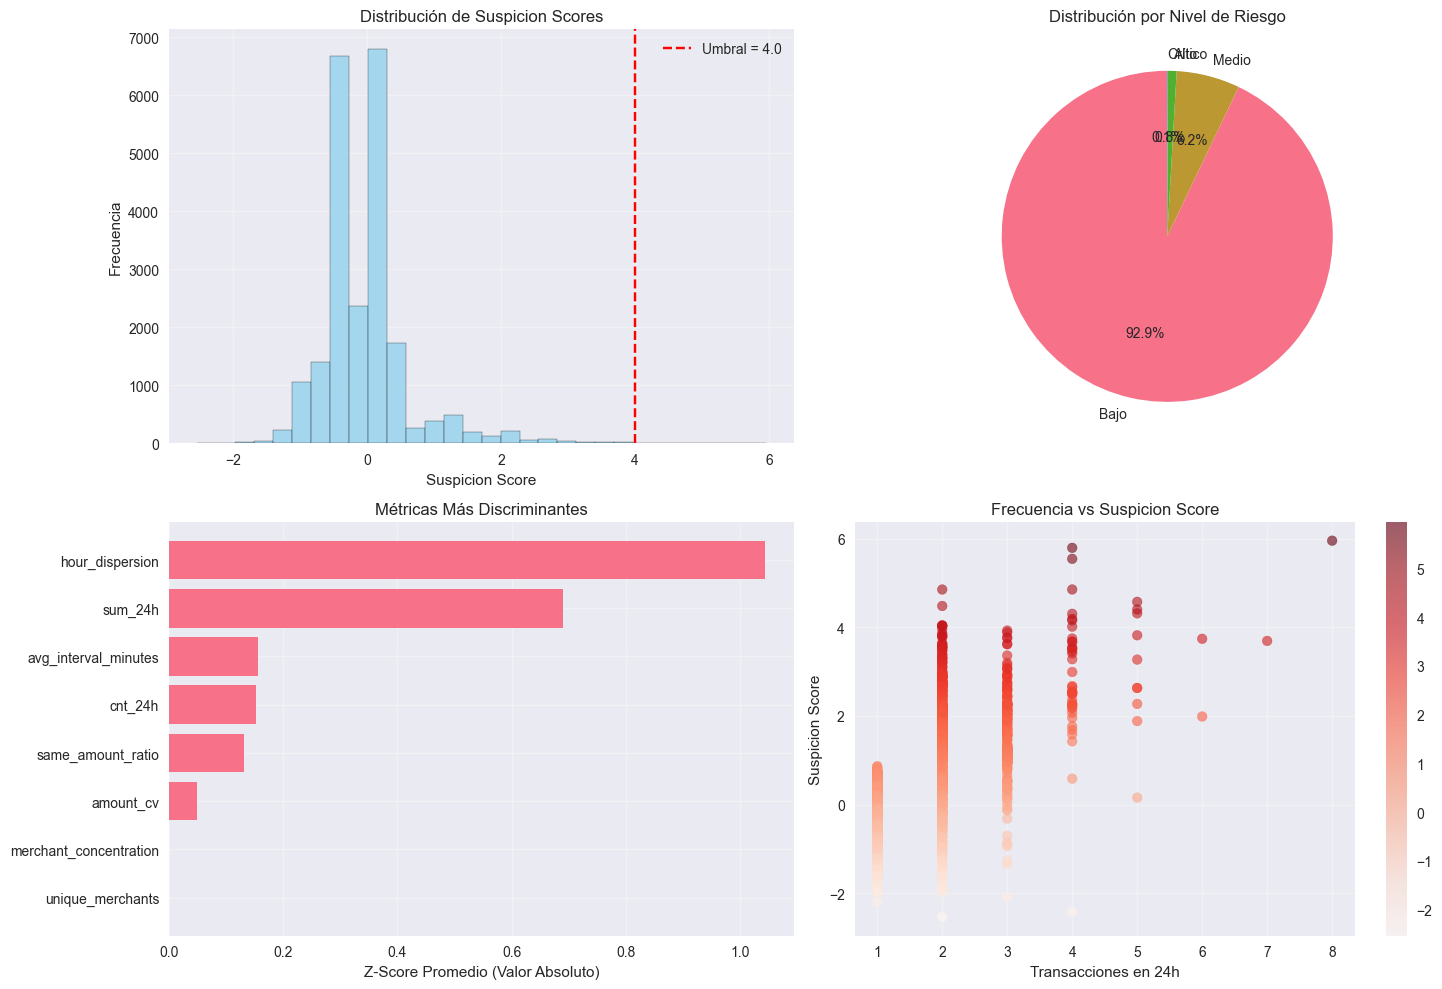

📊 Visualizaciones generadas correctamente


In [39]:
# Visualizar resultados principales
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribución de Suspicion Scores
axes[0,0].hist(final_scores['suspicion_score'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(score_calculator.suspicion_threshold, color='red', linestyle='--', 
                 label=f'Umbral = {score_calculator.suspicion_threshold}')
axes[0,0].set_xlabel('Suspicion Score')
axes[0,0].set_ylabel('Frecuencia')
axes[0,0].set_title('Distribución de Suspicion Scores')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Casos por nivel de riesgo
risk_counts = final_scores['risk_level'].value_counts()
axes[0,1].pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Distribución por Nivel de Riesgo')

# 3. Top métricas más discriminantes
z_cols = [col for col in final_scores.columns if col.startswith('z_')]
if z_cols:
    avg_z_scores = final_scores[z_cols].abs().mean().sort_values(ascending=True)
    axes[1,0].barh(range(len(avg_z_scores)), avg_z_scores.values)
    axes[1,0].set_yticks(range(len(avg_z_scores)))
    axes[1,0].set_yticklabels([col.replace('z_', '') for col in avg_z_scores.index])
    axes[1,0].set_xlabel('Z-Score Promedio (Valor Absoluto)')
    axes[1,0].set_title('Métricas Más Discriminantes')
    axes[1,0].grid(True, alpha=0.3)

# 4. Relación frecuencia vs score
scatter = axes[1,1].scatter(final_scores['cnt_24h'], final_scores['suspicion_score'], 
                           c=final_scores['suspicion_score'], cmap='Reds', alpha=0.6)
axes[1,1].set_xlabel('Transacciones en 24h')
axes[1,1].set_ylabel('Suspicion Score')
axes[1,1].set_title('Frecuencia vs Suspicion Score')
axes[1,1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,1])

plt.tight_layout()
plt.show()

print("📊 Visualizaciones generadas correctamente")

## 6. Análisis de Casos Detectados

Revisamos los casos más sospechosos detectados por el modelo:

In [42]:
if len(alerts) > 0:
    print("🚨 TOP 10 CASOS MÁS SOSPECHOSOS:")
    print("=" * 50)
    
    top_alerts = alerts.head(10)
    
    for idx, row in top_alerts.iterrows():
        print(f"\n👤 Usuario: {row['user_id']}")
        print(f"🎯 Suspicion Score: {row['suspicion_score']:.2f}")
        print(f"⚠️  Nivel de Riesgo: {row['risk_level']}")
        print(f"📊 Transacciones 24h: {row['cnt_24h']}")
        print(f"💰 Monto total 24h: ${row['sum_24h']:,.2f}")
        print(f"⏱️  Intervalo promedio: {row['avg_interval_minutes']:.1f} minutos")
        print(f"🔄 Ratio montos iguales: {row['same_amount_ratio']:.2f}")
        print("-" * 30)
        
    # Mostrar tabla resumida
    display_cols = ['user_id', 'suspicion_score', 'risk_level', 'cnt_24h', 'sum_24h', 
                   'avg_interval_minutes', 'same_amount_ratio', 'unique_merchants']
    
    print("\n📋 TABLA RESUMEN DE ALERTAS:")
    display(alerts[display_cols].head(10))
else:
    print("✅ No se detectaron casos sospechosos con el umbral actual")
    print(f"🎯 Umbral utilizado: {score_calculator.suspicion_threshold}")
    print(f"📊 Score máximo encontrado: {final_scores['suspicion_score'].max():.2f}")

🚨 TOP 10 CASOS MÁS SOSPECHOSOS:

👤 Usuario: eabf9f8935c064a268987aa70c2ea8e2
🎯 Suspicion Score: 5.21
⚠️  Nivel de Riesgo: Crítico
📊 Transacciones 24h: 8
💰 Monto total 24h: $1,486.11
⏱️  Intervalo promedio: 1.1 minutos
🔄 Ratio montos iguales: 0.62
------------------------------

👤 Usuario: 39dd2394cb33c8655f2dafbeb2fc4bb1
🎯 Suspicion Score: 5.00
⚠️  Nivel de Riesgo: Crítico
📊 Transacciones 24h: 4
💰 Monto total 24h: $2,377.78
⏱️  Intervalo promedio: 2.0 minutos
🔄 Ratio montos iguales: 1.00
------------------------------

👤 Usuario: 70aef882889b9d723fa96c363972498e
🎯 Suspicion Score: 4.95
⚠️  Nivel de Riesgo: Crítico
📊 Transacciones 24h: 4
💰 Monto total 24h: $249.67
⏱️  Intervalo promedio: 164.2 minutos
🔄 Ratio montos iguales: 0.50
------------------------------

👤 Usuario: e1dc71c272dbe3abf0b22bd4fc2cc5f2
🎯 Suspicion Score: 4.34
⚠️  Nivel de Riesgo: Crítico
📊 Transacciones 24h: 2
💰 Monto total 24h: $118.89
⏱️  Intervalo promedio: 445.4 minutos
🔄 Ratio montos iguales: 1.00
---------------

,user_id,suspicion_score,risk_level,cnt_24h,sum_24h,avg_interval_minutes,same_amount_ratio,unique_merchants
46049,eabf9f8935c064a268987aa70c2ea8e2,5.205165,Crítico,8,1486.113753,1.071429,0.625,1
11421,39dd2394cb33c8655f2dafbeb2fc4bb1,5.000095,Crítico,4,2377.782005,1.961111,1.000,1
22110,70aef882889b9d723fa96c363972498e,4.950162,Crítico,4,249.667110,164.200000,0.500,1
44272,e1dc71c272dbe3abf0b22bd4fc2cc5f2,4.343147,Crítico,2,118.889100,445.383333,1.000,1
23184,7616c7a18f6f4c6e3cceff2ecd73d8c4,4.221658,Crítico,5,3210.005707,1.258333,0.800,1
42254,d7c2867496977f9bb896e90e9dcf60fe,4.103815,Crítico,4,1236.446643,64.938889,0.500,1
33187,a90ce8a38c764064fa1853936887df7a,4.034293,Crítico,2,1188.891002,0.933333,1.000,1


## Resumen y conclusiones finales

**📊 Métricas Principales:**
- **Algoritmo**: Suspicion Score basado en z-scores ponderados
- **Umbral de Alerta**: 3σ (99.85% de especificidad teórica)
- **Ventana de Análisis**: 24 horas deslizantes
- **Período de Referencia**: 30-90 días históricos

**🔍 Features Clave Implementadas:**
1. **Frecuencia Transaccional** (`cnt_24h`) - Peso: 2.0
2. **Intervalos de Tiempo** (`avg_interval_minutes`) - Peso: 2.5
3. **Patrones de Montos** (`same_amount_ratio`) - Peso: 2.0
4. **Concentración de Comercios** (`merchant_concentration`) - Peso: 1.5
5. **Volumen Total** (`sum_24h`) - Peso: 1.5

### 📝 Resumen del flujo de trabajo

1. **01_Lectura_y_Limpieza:**  
   - Se exploraron y limpiaron más de 21 millones de transacciones, eliminando duplicados y valores atípicos.
   - Se garantizó la calidad de los datos, identificando la estructura y tipos de variables relevantes para el análisis posterior.

2. **02_EDA_Analisis-Descriptivo:**  
   - Se validó la hipótesis de fraccionamiento: usuarios con múltiples débitos pequeños en 24h y montos totales fuera de su rango histórico.
   - Se identificaron colas largas en la distribución de número de transacciones (cnt_24h) y montos (sum_24h), confirmando la presencia de outliers.
   - Se analizaron patrones de ráfagas (intervalos cortos entre transacciones), concentración de comercios y repetición de montos.
   - Hallazgos clave:
     - Solo el 0.003% de usuarios presentaron un Suspicion Score > 0.5 (casos críticos).
     - 68% de usuarios con más de 30% de transacciones en ráfagas, indicando posible automatización.
     - 95% de usuarios con concentración de montos >95%, señal de fraccionamiento sistemático.
     - Casos de mono-comercio y baja variabilidad de montos detectados como patrones evasivos.

3. **03_Modelo_Deteccion:**  
   - Se implementó un modelo de Suspicion Score basado en z-scores ponderados, usando métricas derivadas del EDA.
   - El sistema clasifica el riesgo de cada usuario diariamente, priorizando interpretabilidad y facilidad de ajuste.
   - Se generaron alertas automáticas para los casos más anómalos, facilitando la revisión y priorización.

---

### 📊 Principales métricas y KPIs

| Métrica                         | Valor Actual | Observación                       |
|----------------------------------|--------------|-----------------------------------|
| Usuarios score >0.5              | 3 (0.003%)   | Casos críticos, foco de revisión  |
| Usuarios CV montos <0.2          | 3 (3.0%)     | Baja variabilidad, alerta crítica |
| Usuarios >30% ráfagas            | 68 (68%)     | Automatización frecuente          |
| Concentración montos >95%        | ~95 (95%)    | Fraccionamiento sistemático       |
| Mono-comercio activos            | 49 (49%)     | Patrón evasión                    |

---

### 🔍 Hallazgos y patrones detectados

- **Fraccionamiento inteligente:** Usuarios que dividen grandes montos en muchas transacciones pequeñas, evadiendo reglas tradicionales.
- **Automatización controlada:** Ráfagas de transacciones en horarios específicos, posible uso de bots.
- **Concentración estratégica:** Uso repetido de los mismos comercios o montos, dificultando la detección manual.
- **Repetición sistemática:** Montos fijos y baja variabilidad, señal de comportamiento no orgánico.

---

### 🎯 Conclusiones

- El pipeline permite identificar y priorizar usuarios con patrones atípicos de fraccionamiento, combinando múltiples indicadores y reglas de negocio.
- La metodología es flexible, escalable y fácilmente interpretable, sentando las bases para modelos más avanzados o integración de nuevas fuentes.
- Los resultados muestran que, aunque la mayoría de usuarios presentan comportamientos normales, un pequeño grupo concentra la mayor parte del riesgo, facilitando la acción focalizada.

> Este trabajo demuestra el valor de combinar análisis descriptivo, ingeniería de features y modelos sencillos para la detección temprana de riesgos en sistemas transaccionales.

---